# Capstone Project Flask UI

Pada capstone ini anda diminta untuk membangun sebuah Flask UI sederhana yang berisi beberapa tampilan plot dari skeleton yang sudah disediakan dan satu plot tambahan berdasarkan analisis anda.

File ini dapat dimanfaatkan untuk membantu anda dalam proses wrangling dan visualization. Apabila proses wrangling sudah tepat dan hasil visualisasi sudah sesuai dengan ketentuan, anda dapat memindahkan kembali kode program yang sudah anda lengkapi ke dalam file `app.py`.

## Create Virtual Enviroment 

a. Created virtual environment called "capstone-flask"

Hal pertama yang harus dilakukan adalah melakukan pengaturan environment conda. Untuk menyiapkan conda environment dan kernel, silahkan gunakan command berikut:

```
conda create -n <ENV_NAME> python=3.10
conda activate <ENV_NAME>

conda install ipykernel
python -m ipykernel install --user --name <ENV_NAME>
```

b. Install packages: pandas, flask, matplotlib, dan numpy

Seluruh dependecies telah di-export ke dalam file requirements.txt. Oleh karena itu untuk melakukan install packages, Anda dapat menggunakan perintah berikut:

```
pip install -r requirements.txt --user
```

## Data Preprocessing

**Import library**

In [1]:
from flask import Flask, render_template
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64

**Load data**

Bacalah file `googleplaystore.csv` data dan simpan ke objek dataframe dengan nama playstore

In [2]:
app = Flask(__name__)

In [3]:
playstore = pd.read_csv("data/googleplaystore.csv")

In [4]:
playstore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


**Data Cleansing** 

**_Task 1:_** Hapus data yang duplikat berdasarkan kolom App, dengan tetap keep data pertama (hint : gunakan parameter subset)

In [5]:
playstore.drop_duplicates(subset = "App",keep="first",inplace=True) 

Bagian ini untuk menghapus row 10472 karena nilai data tersebut tidak tersimpan pada kolom yang benar

In [6]:
playstore.drop([10472], inplace=True)

**_Task 2:_** Cek tipe data kolom Category. Jika masih tersimpan dengan format tipe data yang salah, ubah ke tipe data yang sesuai


In [7]:
playstore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9659 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9659 non-null   object 
 1   Category        9659 non-null   object 
 2   Rating          8196 non-null   float64
 3   Reviews         9659 non-null   object 
 4   Size            9659 non-null   object 
 5   Installs        9659 non-null   object 
 6   Type            9658 non-null   object 
 7   Price           9659 non-null   object 
 8   Content Rating  9659 non-null   object 
 9   Genres          9659 non-null   object 
 10  Last Updated    9659 non-null   object 
 11  Current Ver     9651 non-null   object 
 12  Android Ver     9657 non-null   object 
dtypes: float64(1), object(12)
memory usage: 1.0+ MB


In [8]:
playstore.nunique()

App               9659
Category            33
Rating              39
Reviews           5330
Size               461
Installs            21
Type                 2
Price               92
Content Rating       6
Genres             118
Last Updated      1377
Current Ver       2817
Android Ver         33
dtype: int64

In [9]:
playstore.Category = playstore.Category.astype('category')

**_Task 3:_** Pada kolom Installs Buang tanda koma(,) dan tanda tambah(+) kemudian ubah tipe data menjadi integer

In [10]:
playstore.Installs = playstore.Installs.apply(lambda x: x.replace(',',''))
playstore.Installs = playstore.Installs.apply(lambda x: x.replace('+',''))

Bagian ini untuk merapikan kolom Size, Anda tidak perlu mengubah apapun di bagian ini

In [11]:
playstore['Size'].replace('Varies with device', np.nan, inplace = True ) 
playstore.Size = (playstore.Size.replace(r'[kM]+$', '', regex=True).astype(float) * \
             playstore.Size.str.extract(r'[\d\.]+([kM]+)', expand=False)
            .fillna(1)
            .replace(['k','M'], [10**3, 10**6]).astype(int))
playstore['Size'].fillna(playstore.groupby('Category')['Size'].transform('mean'),inplace = True)


**_Task 4:_** Pada kolom Price, buang karakater $ pada nilai Price lalu ubah tipe datanya menjadi float

In [12]:
playstore.Price = playstore.Price.apply(lambda x: x.replace('$',''))
playstore.Price = playstore.Price.astype("float64") 

In [13]:
playstore.dtypes

App                 object
Category          category
Rating             float64
Reviews             object
Size               float64
Installs            object
Type                object
Price              float64
Content Rating      object
Genres              object
Last Updated        object
Current Ver         object
Android Ver         object
dtype: object

Ubah tipe data Reviews, Size, Installs ke dalam tipe data integer

In [14]:
##code here
playstore[['Reviews', 'Size', 'Installs']]=playstore[['Reviews', 'Size', 'Installs']].astype('int64')


## Data Wrangling

In [15]:
df2 = playstore.copy()

**_Task 5:_** Dataframe top_category dibuat untuk menyimpan frekuensi aplikasi untuk setiap Category. 
Gunakan crosstab untuk menghitung frekuensi aplikasi di setiap category kemudian gunakan `Jumlah`
sebagai nama kolom dan urutkan nilai frekuensi dari nilai yang paling banyak. Terakhir reset index dari dataframe top_category.

In [16]:
top_category = pd.crosstab(
            index = df2['Category'],
            columns = 'Jumlah',
            values = df2['Category'],
            aggfunc = 'count'
).sort_values(by='Jumlah', ascending=False).reset_index()

In [17]:
top_category.head()

col_0,Category,Jumlah
0,FAMILY,1832
1,GAME,959
2,TOOLS,827
3,BUSINESS,420
4,MEDICAL,395


**_Task 6:_** Ini adalah bagian untuk melengkapi konten value box 
most category mengambil nama category paling banyak mengacu pada dataframe `top_category`
total mengambil frekuensi/jumlah category paling banyak mengacu pada dataframe `top_category`

In [18]:
most_categories = top_category.loc[0,'Category']
total = top_category.loc[0,'Jumlah']

`rev_table` adalah tabel yang berisi 10 aplikasi yang paling banyak direview oleh pengguna.
Silahkan melakukan agregasi data yang tepat menggunakan `groupby` untuk menampilkan 10 aplikasi yang diurutkan berdasarkan jumlah Review pengguna. 

Tabel yang ditampilkan terdiri dari 4 kolom yaitu nama Category, nama App, total Reviews, dan rata-rata Rating.
Pindahkan kode wrangling yang disimpan dalam variable `rev_table` pada `blank code` yang telah di chaining dengan kode `.to_html`.

In [19]:
rev_table = df2.groupby(by=['Category', 'App']).agg({'Reviews' : 'sum', 'Rating' : 'mean'}).sort_values(by='Reviews', ascending=False).reset_index().head(10)


Apabila menuliskan kode program yang tepat maka hasil wrangling adalah sebagai berikut :

In [20]:
rev_table

,Category,App,Reviews,Rating
0,SOCIAL,Facebook,78158306,4.1
1,COMMUNICATION,WhatsApp Messenger,69119316,4.4
2,SOCIAL,Instagram,66577313,4.5
3,COMMUNICATION,Messenger – Text and Video Chat for Free,56642847,4.0
4,GAME,Clash of Clans,44891723,4.6
5,TOOLS,Clean Master- Space Cleaner & Antivirus,42916526,4.7
6,GAME,Subway Surfers,27722264,4.5
7,VIDEO_PLAYERS,YouTube,25655305,4.3
8,TOOLS,"Security Master - Antivirus, VPN, AppLock, Boo...",24900999,4.7
9,GAME,Clash Royale,23133508,4.6


## Data Visualization

**Membuat Bar Plot**

**_Task 7:_** 
Lengkapi tahap agregasi untuk membuat dataframe yang mengelompokkan aplikasi berdasarkan Category.
Buatlah bar plot dimana axis x adalah nama Category dan axis y adalah jumlah aplikasi pada setiap kategori, kemudian urutkan dari jumlah terbanyak

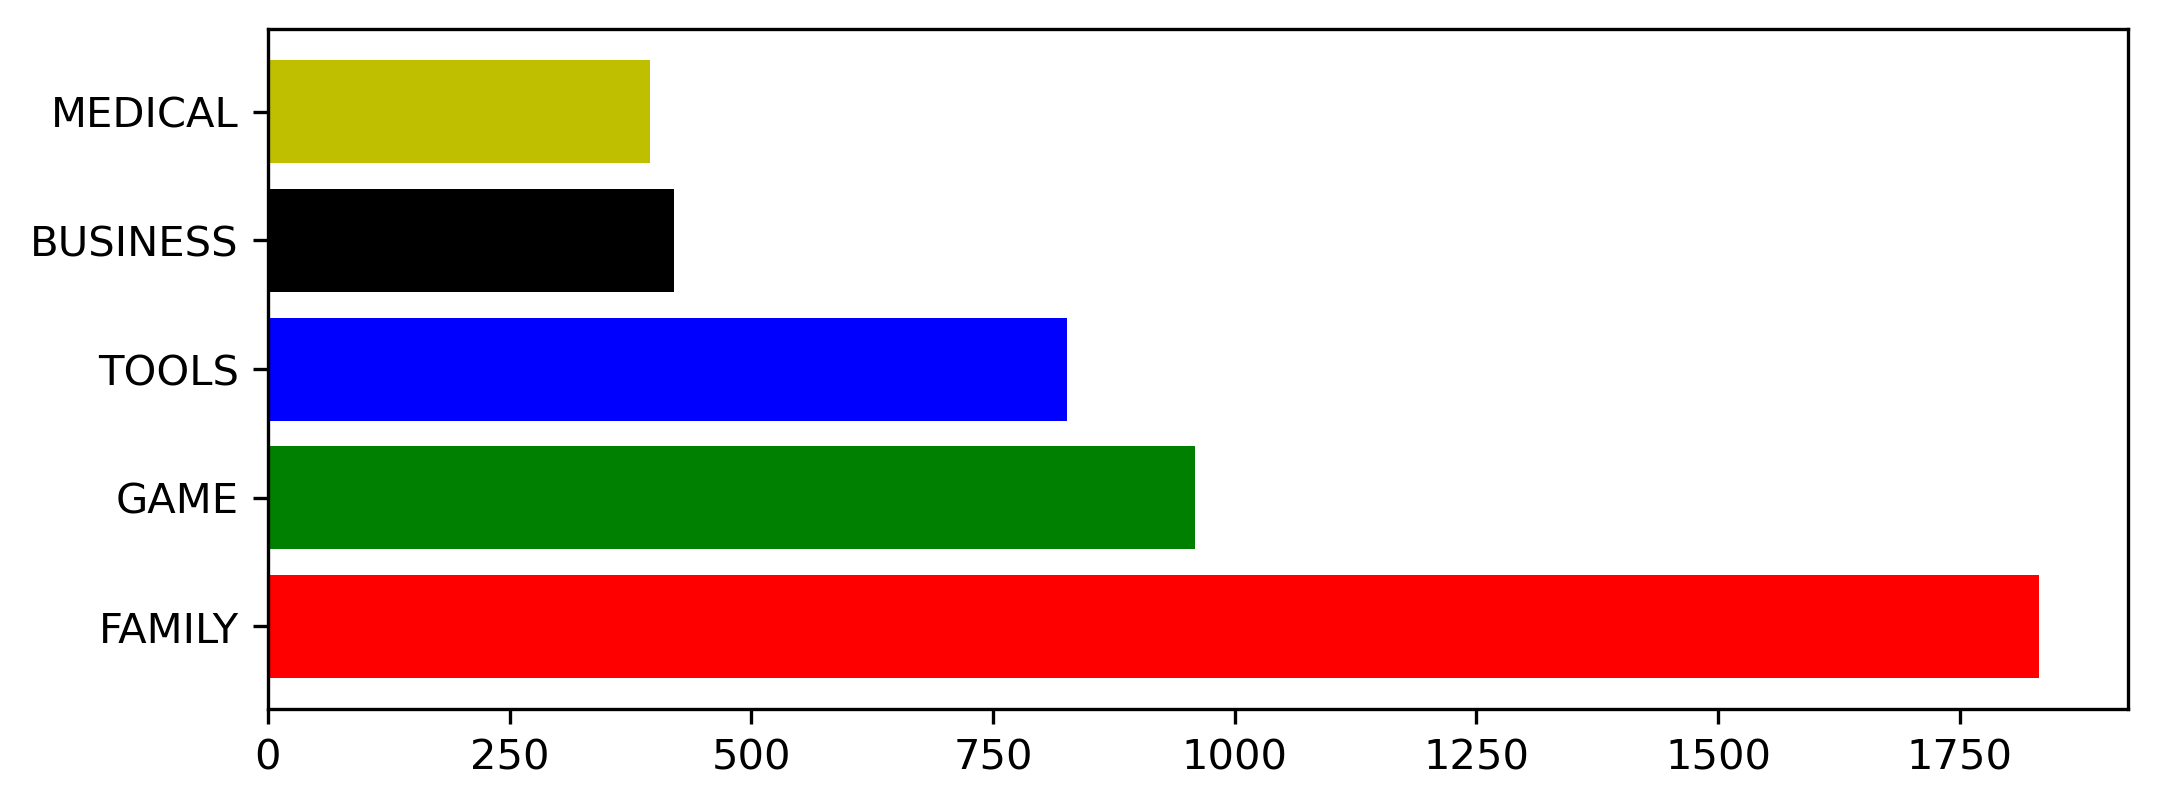

In [21]:
cat_order = df2.groupby('Category').agg({
'Category': 'count'
 }).rename({'Category':'Total'}, axis=1).sort_values(by='Total',ascending=False).head()
X = cat_order.index
Y = cat_order['Total']
my_colors = ['r','g','b','k','y','m','c']
# bagian ini digunakan untuk membuat kanvas/figure
fig = plt.figure(figsize=(8,3),dpi=300)
fig.add_subplot()
# bagian ini digunakan untuk membuat bar plot
plt.barh(X, Y, color=my_colors)
# bagian ini digunakan untuk menyimpan plot dalam format image.png
plt.savefig('cat_order.png',bbox_inches="tight") 

**Membuat Scatter Plot**

**_Task 8:_** Buatlah scatter plot untuk menampilkan hubungan dan persebaran apalikasi dilihat dari Review vs Rating.
Ukuran scatter menggambarkan berapa banyak pengguna yang telah menginstall aplikasi 
    

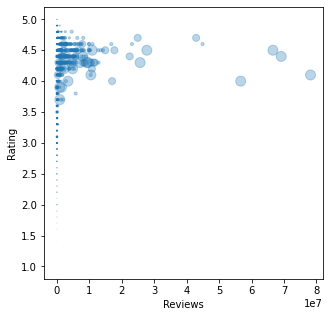

In [22]:
X = df2['Reviews'].values # axis x
Y = df2['Rating'].values # axis y
area = playstore['Installs'].values/10000000 # ukuran besar/kecilnya lingkaran scatter plot
fig = plt.figure(figsize=(5,5))
fig.add_subplot()
# isi nama method untuk scatter plot, variabel x, dan variabel y
plt.scatter(x=X,y=Y, s=area, alpha=0.3)
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.savefig('rev_rat.png',bbox_inches="tight")

**Membuat Histogram Size Distribution**

**_Task 9:_** Buatlah sebuah histogram yang menggambarkan distribusi Size aplikasi dalam satuan Mb(Megabytes). Histogram yang terbentuk terbagi menjadi 100 bins

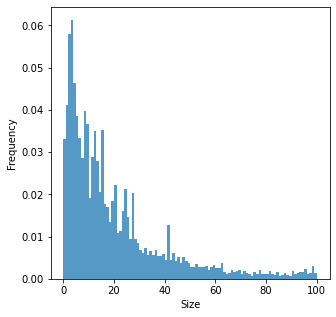

In [23]:
X=(df2['Size']/1000000).values
fig = plt.figure(figsize=(5,5))
fig.add_subplot()
plt.hist(X,bins=100, density=True,  alpha=0.75)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.savefig('hist_size.png',bbox_inches="tight")

**_Task 10:_** Buatlah plot berdasarkan hasil analisis anda. Plot yang dibuat tidak diperbolehkan sama dengan plot yang sudah dicontohkan.

**Membuat Histogram Category 'Family'**

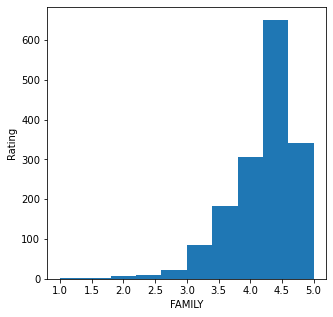

In [24]:
## code here
X = df2[df2.Category == 'FAMILY']['Rating']
fig = plt.figure(figsize=(5,5))
fig.add_subplot()
plt.hist(X)
plt.xlabel('FAMILY')
plt.ylabel('Rating')
plt.savefig('histogram.png',bbox_inches="tight")

